In [1]:
import torch.nn as nn
import torch
from torch.optim import SGD
from torch.optim import RMSprop
from torch.optim import Adam
import math
import numpy as np
import csv
import matplotlib.pyplot as plt
import torch.utils.tensorboard as tensorboard
from torch.autograd import Variable  
import datetime
import tqdm

In [2]:
#1時間ごとでの
with open('2022_nikkei_225.csv') as f:
    reader = csv.reader(f)
    l = [row for row in reader]
    hours_data = [int(l[i*60][2]) for i in range(2, len(l) // 60)]
    h_data = np.array(hours_data)

In [3]:
def normalization(data):
    avg = np.mean(data)
    std = np.std(data)
    data = (data - avg) / std
    return data

In [4]:
h_data = normalization(h_data)

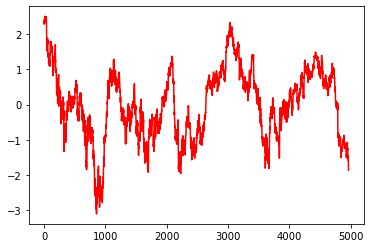

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(h_data, color = "r")

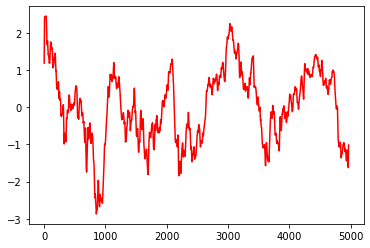

In [6]:
window = 10 # 移動平均の範囲
w = np.ones(window)/window

h_data_convolve = np.convolve(h_data, w, mode='same').astype(np.float32)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(h_data_convolve, color = "r")

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [8]:
def value_s(np_array, rate = 0.9):
    sum = 0
    if (len(np_array) < 100):
        for n, r in enumerate(np_array):
            sum += rate ** n * (r - np_array[0])
    else:
        for n in range(100):
            sum += rate ** n * (np_array[n] - np_array[0])
    return sum

def mkDataSet(data_size, data_length):
    train_x = []
    train_t = []
    freq=60.
    for offset in range(data_size):
        train_x.append([[h_data_convolve[offset+i]] for i in range(data_length)])
        train_t.append([value_s(h_data_convolve[offset+data_length:-1])])
        
    return train_x, train_t

def mkBatchSet(train_x, train_t, batch_size):
    batch_x = []
    batch_t = []    
    for _ in range(batch_size):
        idx = np.random.randint(0, len(train_x)-1)
        batch_x.append(train_x[idx])
        batch_t.append(train_t[idx])
        
    batch_x = np.array(batch_x).astype(np.float32)
    batch_t = np.array(batch_t).astype(np.float32)

    return torch.from_numpy(batch_x).clone().reshape(batch_size, 1, -1).to(device), torch.from_numpy(batch_t).clone().to(device)

In [9]:
data_length = 250
training_size = len(h_data)-data_length
epoch_num = 10000
hidden_size = 10
batch_size = 32

train_x, train_t = mkDataSet(training_size, data_length)
data, label = mkBatchSet(train_x, train_t, batch_size)

In [10]:
class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()
        self.hiddenDim = hiddenDim
        self.kernel_size1 = 100
        self.kernel_size2 = 50
        self.kernel_size3 = 20
        self.seq_len = ((inputDim - self.kernel_size1 + 1) - self.kernel_size2 + 1) - self.kernel_size3 + 1
        
        self.conv1d_1 = nn.Conv1d(1, 3, self.kernel_size1)
        self.relu1 = nn.ReLU()
        self.conv1d_2 = nn.Conv1d(3, 3, self.kernel_size2)
        self.relu2 = nn.ReLU()
        self.conv1d_3 = nn.Conv1d(3, 1, self.kernel_size3)
        self.rnn = nn.LSTM(input_size=1, hidden_size=hiddenDim, batch_first=True) #batch_first=Trueで(seq, batch, vec)->(batch, seq, vec)に入力の形を変更
        self.output_layer = nn.Linear(hiddenDim, outputDim)

    def forward(self, input):
        output = self.conv1d_1(input)
        output = self.relu1(output)
        output = self.conv1d_2(output)
        output = self.relu2(output)
        output = self.conv1d_3(output)
        h_0 = None
        output = output.reshape(-1, self.seq_len, 1)
        output, (hidden, cell) = self.rnn(output, (h_0)) #LSTMのforwardのreturnはこのような戻り値になっている
        output = self.output_layer(output[:, -1, :]) #LSTMのoutput=(batch, seq, hidden)からseqのみ最後のやつだけを取り出す
        return output

In [11]:
model = Predictor(data_length, hidden_size, 1).to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

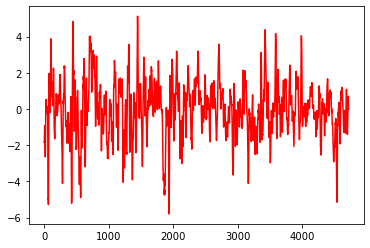

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(train_t, color = "r")

In [13]:
loss_history = []
for epoch in tqdm.tqdm(range(epoch_num)):
    optimizer.zero_grad()
    data, label = mkBatchSet(train_x, train_t, batch_size)
    output = model(data)

    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    running_loss = torch.sum(loss.data)
    loss_history.append(running_loss.to('cpu').detach().numpy().copy())
    
    if (epoch+1) % 1000 == 0:
        print('%d loss: %3f' % (epoch+1, running_loss))

 10% 1031/10000 [00:05<00:43, 208.31it/s]

1000 loss: 2.104451


 20% 2023/10000 [00:10<00:38, 207.51it/s]

2000 loss: 1.555249


 30% 3032/10000 [00:15<00:33, 209.56it/s]

3000 loss: 1.764685


 40% 4031/10000 [00:20<00:28, 208.17it/s]

4000 loss: 1.403383


 50% 5031/10000 [00:24<00:24, 203.95it/s]

5000 loss: 1.196601


 60% 6021/10000 [00:31<00:35, 113.38it/s]

6000 loss: 1.440798


 70% 7017/10000 [00:40<00:26, 112.17it/s]

7000 loss: 2.484393


 80% 8038/10000 [00:44<00:09, 216.20it/s]

8000 loss: 2.370652


 90% 9037/10000 [00:49<00:04, 217.16it/s]

9000 loss: 2.059258


100% 10000/10000 [00:54<00:00, 185.09it/s]

10000 loss: 2.656335


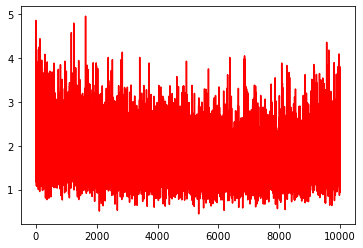

In [14]:
loss_history = np.array(loss_history)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(loss_history, color = "r")

In [15]:
state = 0 #0->1で買い　1->0で売り
reward = 0.
last_output = 0.
buy_chart = 0.
with torch.no_grad():
    for test_data in train_x:
        output = model(torch.tensor(test_data).reshape(1, 1, -1).to(device))
        if output.data > last_output:
            if state == 0:
                reward += test_data[-1][0] - buy_chart
            state = 1
        else:
            if state == 1:
                buy_chart = test_data[-1][0]
            state = 0
        last_output = output.data
        
print(reward)

11.609044902026653


In [16]:
# def mkRandomBatch(train_x, train_t, batch_size=10):
#     batch_x = []
#     batch_t = []
    
#     for _ in range(batch_size):
#         idx = np.random.randint(0, len(train_x)-1)
#         batch_x.append(train_x[idx])
#         batch_t.append(train_t[idx])
    
#     return torch.tensor(batch_x), torch.tensor(batch_t)

In [17]:
# batch_size = 10

# for epoch in range(epoch_num):
#     running_loss = 0.0
#     last_training_accuracy = 0.0
#     correct = 0.0
#     for i in range(int(training_size / batch_size)):
#         optimizer.zero_grad()
#         data, label = mkRandomBatch(train_x, train_t, batch_size)

#         output = model(data)

#         loss = criterion(output, label)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.data
#         correct += np.sum(np.abs((output.data - label.data).numpy()) < 0.1)
    
#     training_accuracy = correct / training_size
#     print('%d loss: %3f, training_accuracy: %.5f' % (epoch+1, running_loss, training_accuracy))
#     if last_training_accuracy > training_accuracy:
#         break
#     last_training_accuracy = training_accuracy